# JOBMadrid | Clasificador de erupciones volcánicas

Objetivo: realizar un modelo predictivo basado en Random Forests que permita conocer el tipo de erupción que tendrá un volcán en función de las vibraciones medidas por los sensores.

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, mean_squared_error

Cargamos los datasets train y test que muestran los datos de las 6 features y la columna target con las labels para cada conjunto de medidas de los sensores, dentro de las posibles 5

In [166]:
df = pd.read_csv('jm_train.csv')
dfXtest = pd.read_csv('jm_X_test.csv')
df

,feature1,feature2,feature3,feature4,feature5,feature6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0
...,...,...,...,...,...,...,...
2095,-0.947002,0.174969,-0.180249,0.118236,-0.143420,-0.359509,0
2096,-1.224148,0.029956,0.536684,0.888406,0.119460,0.378946,1
2097,-0.847593,1.538574,0.962409,1.966467,0.379934,0.737907,3
2098,1.472437,1.187695,1.015766,-1.103522,1.586722,0.182569,4


In [105]:
dfXtest

,feature1,feature2,feature3,feature4,feature5,feature6
0,0.943723,-2.985473,-0.938218,3.580261,-3.038106,2.080338
1,-0.899819,1.295568,1.274513,0.718186,1.117035,0.463068
2,0.293281,-0.099317,1.874902,-0.589582,1.828441,1.011596
3,-1.134804,0.888585,-1.464499,-1.183056,-0.525729,-1.963822
4,-0.909240,1.575797,0.697212,1.197092,0.486185,0.222644
...,...,...,...,...,...,...
895,0.196663,-0.866822,-1.132836,-0.700726,-0.886717,-0.680351
896,1.306644,0.543675,0.555275,-0.518374,0.796236,0.297632
897,-1.009089,0.359536,-2.253087,0.125687,-1.881437,-1.704497
898,-0.339431,-0.560891,-0.256911,-1.576351,0.317480,-0.742085


### Estudiamos los datos del dataset

In [5]:
# Porcentaje de NaNs en cada columna
df.isna().sum()/len(df)*100 

feature1    0.0
feature2    0.0
feature3    0.0
feature4    0.0
feature5    0.0
feature6    0.0
target      0.0
dtype: float64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   target    2100 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 115.0 KB


Vemos que no hay NaNs en el dataframe y que todos los datos son numéricos. No tenemos datos nulos o extraños que tengamos que imputar o que nos hagan eliminar filas o columnas.

In [6]:
df.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.204656,0.199249,-0.378140,-0.206425,-0.186419,-0.433229,1.980476
std,1.543613,1.614024,1.450548,1.442225,1.501573,1.188791,1.410537
min,-6.683655,-5.383371,-6.147055,-5.653594,-5.912521,-4.433189,0.000000
25%,-1.171340,-0.877386,-1.365990,-1.259403,-1.211685,-1.131944,1.000000
50%,-0.443868,0.320507,-0.439745,-0.176504,-0.195751,-0.406754,2.000000
75%,0.890023,1.321430,0.662898,0.866879,0.851843,0.348593,3.000000
max,4.565547,6.700133,4.157518,4.371912,5.068783,4.016324,4.000000


Los datos de las 6 features están en una escala relativa entre ellos muy cercana, por lo que no sería necesario escalar. Además, el RandomForest no necesita que escalemos valores.

Separamos el dataframe en X e y:

In [220]:
X = df.drop("target",axis=1)
y = df["target"]

Ploteamos gráficos de boxplot y violín de los datos de cada feature para ver su distribución:

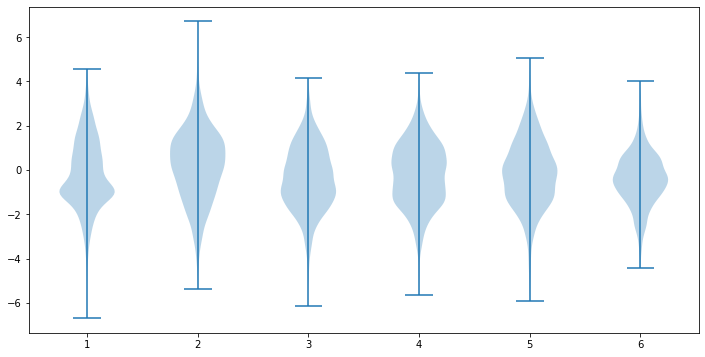

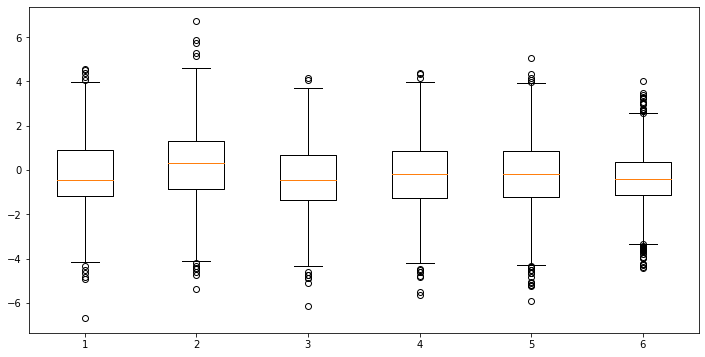

In [227]:
plt.figure(figsize=(12,6))
plt.violinplot(X)

plt.figure(figsize=(12,6))
plt.boxplot(X)

plt.show()

Procedemos a hacer OLS de forma iterativa, comparando cada columna de las features con el resto de features para ver si tenemos columnas muy relacionadas entre sí que no aportarían al modelo a la hora de predecir el target. Es decir, buscamos si tenemos columnas que sean combinación lineal de las otras.

In [13]:
for i in X.columns:
    x1 = X[i]
    x2 = X.drop(i, axis=1)

    slr_model = sm.OLS(x1, x2)
    slr_reg = slr_model.fit()
    print(i)
    print(slr_reg.summary())
    print('')
    print('*'*100)
    print('')

feature1
                                 OLS Regression Results                                
Dep. Variable:               feature1   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.287e+32
Date:                Sat, 20 Nov 2021   Prob (F-statistic):                        0.00
Time:                        22:44:56   Log-Likelihood:                          67148.
No. Observations:                2100   AIC:                                 -1.343e+05
Df Residuals:                    2096   BIC:                                 -1.343e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Es reseñable que la columna feature3 tiene un coeficiente relativamente cercano a 0 respecto a las columnas feature2 y feature4 (-0.0074 y 0.0791 respectivamente), lo cual nos indica que feature3 está bastante relacionada con ambas y es posible que nuestro modelo predictivo sea más preciso si no la tenemos en cuenta. 

### Métodos predictivos

Primero haremos Random Forests con los parámetros por default y miraremos qué f1-score y matriz de confusión obtenemos.
Después probaremos a hacer un GridSearch con RandomForestClassifier para ver si logramos que el f1-score mejore y por último probaremos a hacer el mejor método que hayamos obtenido a:
- el dataframe habiendo quitado la columna 3
- un nuevo dataframe de 5 features habiendo aplicado PCA

In [228]:
# Hacemos train_test_split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Random Forest con parámetros por defecto:

In [229]:
# Aplicamos RandomForest
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('Accuracy score: ', accuracy_score(y_test,yhat))
print('F1-score: ', f1_score(y_test,yhat, average="macro"))
print('Mean squared error: ', mean_squared_error(y_test,yhat) )
confusion_matrix(y_test, yhat)

Accuracy score:  0.7777777777777778
F1-score:  0.7753482071608226
Mean squared error:  0.7031746031746032


array([[111,  10,   6,   3,   1],
       [ 10, 102,  11,  14,   1],
       [  6,   5,  77,   7,  18],
       [  5,   6,   8, 107,  13],
       [  3,   0,   7,   6,  93]], dtype=int64)

Hemos obtenido un f1-score de 0.77 aplicando un Random Forest con los parámetros por defecto

Veamos el número de nodos y hojas que tienen los árboles obtenidos:

In [232]:
print([t.get_depth() for t in clf.estimators_]) 
print([t.get_n_leaves() for t in clf.estimators_])

[17, 16, 19, 16, 15, 19, 17, 17, 16, 18, 18, 16, 16, 18, 15, 19, 16, 17, 18, 17, 18, 15, 17, 16, 16, 16, 16, 16, 14, 16, 17, 17, 16, 17, 19, 18, 17, 15, 17, 17, 18, 16, 17, 15, 17, 16, 16, 17, 15, 17, 18, 22, 17, 17, 19, 17, 15, 15, 17, 16, 17, 16, 20, 16, 18, 15, 15, 16, 16, 16, 18, 16, 15, 18, 16, 15, 16, 23, 16, 20, 19, 15, 16, 17, 16, 17, 17, 14, 18, 18, 15, 18, 18, 19, 18, 20, 17, 19, 14, 15]
[279, 305, 283, 270, 267, 291, 281, 298, 306, 283, 277, 273, 271, 292, 291, 288, 278, 280, 278, 287, 297, 290, 278, 296, 290, 292, 283, 274, 295, 296, 284, 291, 286, 277, 275, 270, 270, 309, 291, 297, 292, 282, 284, 252, 269, 297, 297, 288, 306, 289, 291, 305, 292, 273, 301, 288, 290, 270, 287, 273, 287, 308, 312, 284, 287, 301, 296, 302, 287, 288, 314, 273, 277, 297, 280, 287, 278, 269, 294, 303, 275, 296, 280, 277, 270, 281, 285, 273, 283, 302, 272, 292, 283, 277, 292, 280, 288, 287, 298, 298]


Es reseñable observar que todos tienen un alto número de nodos (todos con más del doble del número de features) y alto número de hojas, de forma que es presumible que podamos tener sobreentrenamiento. Sería interesante encontrar árboles fiables con menos hojas, pero en este ejercicio lo que nos priorizará será la f1-score obtenida.

In [ ]:
A continuación graficamos la distribución de las probabilidades con las que el modelo tenía seguridad de acertar, con predict_proba:

In [233]:
predictproba=[]
for i in clf.predict_proba(X_test):
    predictproba.append(max(i))
predictproba

dfproba=pd.DataFrame()
dfproba['y']=y_test
dfproba['yhat']=yhat
dfproba['proba']=predictproba
dfproba
prob_err_val=dfproba[dfproba['y']!=dfproba['yhat']]['proba'].values
prob_aci_val=dfproba[dfproba['y']==dfproba['yhat']]['proba'].values

Histograma de la seguridad del modelo cuando acertó:

(array([ 5., 13., 27., 33., 52., 53., 75., 52., 89., 91.]),
 array([0.3 , 0.37, 0.44, 0.51, 0.58, 0.65, 0.72, 0.79, 0.86, 0.93, 1.  ]),
 <BarContainer object of 10 artists>)

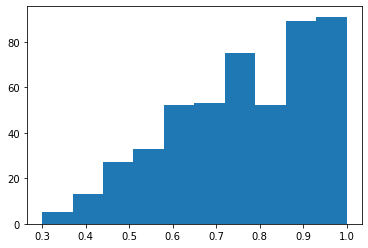

In [234]:
plt.hist(prob_aci_val)

Histograma de la seguridad del modelo cuando falló:

(array([ 7., 18., 14., 32., 18., 25.,  6.,  8.,  7.,  5.]),
 array([0.29 , 0.359, 0.428, 0.497, 0.566, 0.635, 0.704, 0.773, 0.842,
        0.911, 0.98 ]),
 <BarContainer object of 10 artists>)

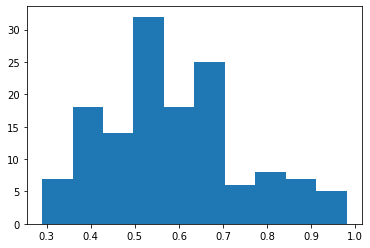

In [235]:
plt.hist(prob_err_val)

Histograma total de la seguridad del modelo:

(array([13., 32., 46., 64., 72., 70., 82., 62., 95., 94.]),
 array([0.29 , 0.361, 0.432, 0.503, 0.574, 0.645, 0.716, 0.787, 0.858,
        0.929, 1.   ]),
 <BarContainer object of 10 artists>)

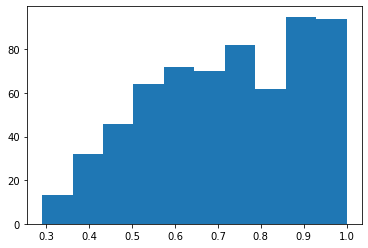

In [236]:
plt.hist(predictproba)

Se observa que había relativamente bastantes y falladas para las que el modelo estaba muy seguro de acertar, pero la gran mayoría tenían baja seguridad

Los parámetros del árbol clasificador con el que hemos obtenido este resultado:

In [66]:
# Parámetros del árbol clasificador con el que hemos obtenido este resultado:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Validamos el método aplicando un k-fold:

In [246]:
Xarr = np.array(X)
kf = KFold(n_splits=10)
kfoldf1sc = []
lista_mse=[]
lista_acc=[]
for train_index, test_index in kf.split(Xarr, y):
    X_train, X_test = Xarr[train_index], Xarr[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf= RandomForestClassifier()
    clf = clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    kfoldf1sc.append(f1_score(y_test,yhat, average='macro'))
    lista_acc.append(accuracy_score(y_test,yhat))
    lista_mse.append(mean_squared_error(y_test,yhat))
print('accuracy medio: ', sum(lista_acc)/len(lista_acc))
print('f1-score media: ', sum(kfoldf1sc)/len(kfoldf1sc))
print('Mean squared error media: ', sum(lista_mse)/len(lista_mse) )

accuracy medio:  0.7733333333333332
f1-score media:  0.7723026340492368
Mean squared error media:  0.7285714285714284


Y aplicamos también hold out 100 veces:

In [245]:
# hold out
lista_acc=[]
lista_f1=[]
lista_mse=[]
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    lista_acc.append(accuracy_score(y_test,yhat))
    lista_f1.append(f1_score(y_test,yhat,average='macro'))
    lista_mse.append(mean_squared_error(y_test,yhat))
print('accuracy medio: ', sum(lista_acc)/len(lista_acc))
f1mean=sum(lista_f1)/len(lista_f1)
print('F1-score media: ', f1mean)
print('Mean squared error media: ', sum(lista_mse)/len(lista_mse) )

accuracy medio:  0.766047619047619
F1-score media:  0.7650998352375196
Mean squared error media:  0.7624761904761903


Obtenemos una media de f1-score de 0.73 y una mean squared error media de 0.69 en la validación con un k-fold de 100 splits, y 0.76 de f1-score media y 0.76 de mean squared error media con hold out de 100

Miramos la relevancia que ha tenido cada columna en el cálculo de yhat con feature_importances:

[0.23332732 0.20131916 0.11942015 0.15165835 0.13871737 0.15555765]


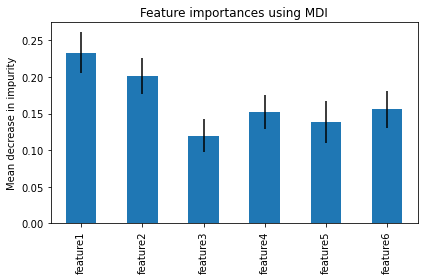

In [242]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
print(importances)

De nuevo observamos que feature3 es la columna menos relevante

#### GridSearch de RandomForestClassifier:

Establecemos una serie de parámetros posibles para el RandomForest y buscamos cuál es la mejor combinación de ellos con GridSearch.

Los parámetros a usar son:

criterion: gini y entropy

max_depth: Desde algo más que el número de columnas (7), hasta algo más del doble (16)

n_jobs: -1

max_leaf_nodes: Desde unas 4 veces el número de etiquetas hasta algo más del doble


In [243]:
clf2 = RandomForestClassifier()
parametros = {'criterion':['entropy','gini'],
             'max_depth':[7,8,10,12,14,16],
             'n_jobs':[-1],
              'max_leaf_nodes': [21,24,30,36,42,48,]
             }

grid = GridSearchCV(estimator = clf2,
                    param_grid = parametros,
                    scoring = 'f1_macro',
                    n_jobs = -1 )

search_result = grid.fit(X,y)
search_result.best_params_

{'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 48, 'n_jobs': -1}

In [199]:
search_result.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=12, max_leaf_nodes=48,
                       n_jobs=-1)

Obtenemos como mejores parámetros: 
    
{'criterion': 'entropy', 'max_depth': 12, 'max_leaf_nodes': 48, 'n_jobs': -1}

Hacemos RandomForest con los parámetros obtenidos:

In [250]:
clf = search_result.best_estimator_  #(criterion='entropy',max_depth=12,max_leaf_nodes=48,n_jobs=-1)
clf = clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test,yhat))
print('F1-score: ', f1_score(y_test,yhat, average="macro"))
print('Mean squared error: ', mean_squared_error(y_test,yhat) )
confusion_matrix(y_test, yhat)

Accuracy:  0.7333333333333333
F1-score:  0.7228858409495853
Mean squared error:  0.6190476190476191


array([[40,  3,  6,  1,  0],
       [ 5, 19,  6,  6,  0],
       [ 1,  5, 25,  3,  4],
       [ 0,  3,  4, 35,  3],
       [ 0,  0,  2,  4, 35]], dtype=int64)

Hemos obtenido un f1-score de 0.72 y un mean squared error de 0.61

Vemos también aquí gráficamente la distribución de las probabilidades cuando falla y cuando acierta:

In [201]:
predictproba=[]
for i in clf.predict_proba(X_test):
    predictproba.append(max(i))
predictproba

dfproba=pd.DataFrame()
dfproba['y']=y_test
dfproba['yhat']=yhat
dfproba['proba']=predictproba
dfproba
prob_err_val=dfproba[dfproba['y']!=dfproba['yhat']]['proba'].values
prob_aci_val=dfproba[dfproba['y']==dfproba['yhat']]['proba'].values

(array([11., 20., 44., 42., 47., 81., 82., 54., 39., 47.]),
 array([0.28572093, 0.35134958, 0.41697822, 0.48260687, 0.54823552,
        0.61386417, 0.67949282, 0.74512146, 0.81075011, 0.87637876,
        0.94200741]),
 <BarContainer object of 10 artists>)

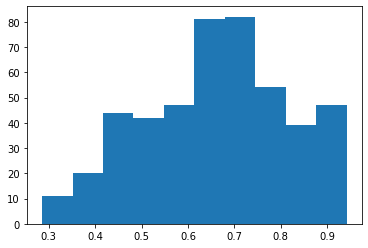

In [202]:
plt.hist(prob_aci_val)

(array([15., 17., 19., 34., 28., 22., 13.,  9.,  2.,  4.]),
 array([0.29367941, 0.35443617, 0.41519293, 0.47594969, 0.53670646,
        0.59746322, 0.65821998, 0.71897674, 0.7797335 , 0.84049026,
        0.90124702]),
 <BarContainer object of 10 artists>)

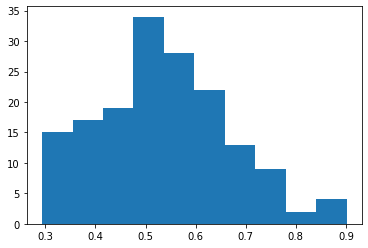

In [203]:
plt.hist(prob_err_val)

(array([ 26.,  38.,  65.,  78.,  74., 104.,  95.,  59.,  40.,  51.]),
 array([0.28572093, 0.35134958, 0.41697822, 0.48260687, 0.54823552,
        0.61386417, 0.67949282, 0.74512146, 0.81075011, 0.87637876,
        0.94200741]),
 <BarContainer object of 10 artists>)

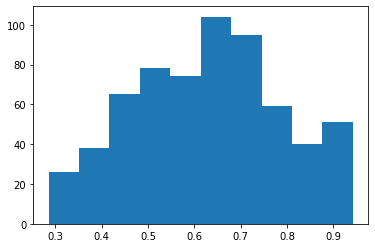

In [204]:
plt.hist(predictproba)

Este modelo parece presentar una mejor distribución de seguridad tanto cuando falla como cuando acierta

Validamos con k-fold:

In [251]:
Xarr = np.array(X)
kf = KFold(n_splits=10)
kfoldf1sc = []
lista_mse=[]
lista_acc=[]
for train_index, test_index in kf.split(Xarr, y):
    X_train, X_test = Xarr[train_index], Xarr[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = search_result.best_estimator_
    clf = clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    kfoldf1sc.append(f1_score(y_test,yhat, average='macro'))
    lista_acc.append(accuracy_score(y_test,yhat))
    lista_mse.append(mean_squared_error(y_test,yhat))
print('accuracy medio: ', sum(lista_acc)/len(lista_acc))
print('f1-score media: ', sum(kfoldf1sc)/len(kfoldf1sc))
print('Mean squared error media: ', sum(lista_mse)/len(lista_mse) )

accuracy medio:  0.7380952380952381
f1-score media:  0.7350329305468871
Mean squared error media:  0.8504761904761905


Obtenemos una media de 0.73 de f1-score y una mean squared error media de 0.75

Hacemos también hold out:

In [252]:
# Aplico hold out
lista_acc=[]
lista_f1=[]
lista_mse=[]
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, stratify=y)
    clf = search_result.best_estimator_
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    #print("Accuracy: ", accuracy_score(y_test,yhat))
    lista_acc.append(accuracy_score(y_test,yhat))
    lista_f1.append(f1_score(y_test,yhat,average='macro'))
    lista_mse.append(mean_squared_error(y_test,yhat))
print('accuracy medio: ', sum(lista_acc)/len(lista_acc))
f1mean=sum(lista_f1)/len(lista_f1)
print('F1-score media: ', f1mean)
# print('Desviación estandar de la f1: ', (sum([(i-f1mean)**2 for i in lista_f1])/len(lista_f1))**(1/2))
print('Mean squared error media: ', sum(lista_mse)/len(lista_mse) )

accuracy medio:  0.7367142857142857
F1-score media:  0.7355857626346305
Mean squared error media:  0.8488730158730159


Hasta ahora nos ha dado mejor resultado usar RandomForest con los parámetros por defecto así que probaremos eso con las siguientes configuraciones. Aunque de cara a tener un método con menos fallos en los casos en los que está muy seguro de acertar, convendría explorar combinaciones de árboles con menos hojas, o tal entrenar árboles especializados en alguna etiqueta minoritaria haciendo oversampling con SMOTE y combinarlos con árboles default.

Para este ejercicio sin embargo nos ceñiremos a RandomForest default.

#### RandomForest con parámetros por defecto, eliminando feature3

In [253]:
X3 = X.drop('feature3', axis=1)

In [254]:
# Hacemos train_test_split:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.3)

In [255]:
# Aplicamos RandomForest
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test,yhat))
print('F1-score: ', f1_score(y_test,yhat, average="macro"))
print('Mean squared error: ', mean_squared_error(y_test,yhat) )
confusion_matrix(y_test, yhat)

Accuracy:  0.7571428571428571
F1-score:  0.7578506858411176
Mean squared error:  0.7253968253968254


array([[104,  17,   7,   3,   0],
       [  4,  96,   8,  14,   0],
       [  9,  10,  86,  13,  15],
       [  4,  13,   5,  98,  11],
       [  3,   1,   7,   9,  93]], dtype=int64)

Obtenemos un f1-score de 0.75

Validamos el método con k-fold:

Vemos gráficamente la distribución de las seguridades:

In [216]:
predictproba=[]
for i in clf.predict_proba(X_test):
    predictproba.append(max(i))
predictproba

dfproba=pd.DataFrame()
dfproba['y']=y_test
dfproba['yhat']=yhat
dfproba['proba']=predictproba
dfproba
prob_err_val=dfproba[dfproba['y']!=dfproba['yhat']]['proba'].values
prob_aci_val=dfproba[dfproba['y']==dfproba['yhat']]['proba'].values

En los aciertos:

(array([ 5., 13., 27., 33., 52., 53., 75., 52., 89., 91.]),
 array([0.3 , 0.37, 0.44, 0.51, 0.58, 0.65, 0.72, 0.79, 0.86, 0.93, 1.  ]),
 <BarContainer object of 10 artists>)

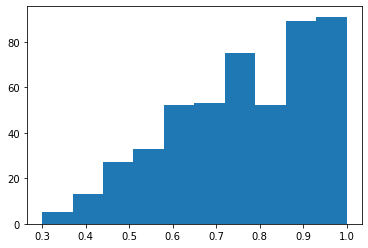

In [256]:
plt.hist(prob_aci_val)

En los errores:

(array([ 7., 18., 14., 32., 18., 25.,  6.,  8.,  7.,  5.]),
 array([0.29 , 0.359, 0.428, 0.497, 0.566, 0.635, 0.704, 0.773, 0.842,
        0.911, 0.98 ]),
 <BarContainer object of 10 artists>)

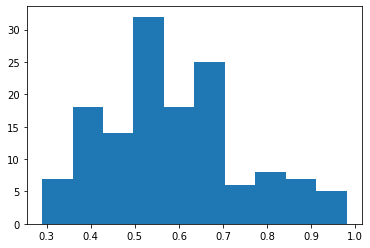

In [257]:
plt.hist(prob_err_val)

Todos:

(array([13., 32., 46., 64., 72., 70., 82., 62., 95., 94.]),
 array([0.29 , 0.361, 0.432, 0.503, 0.574, 0.645, 0.716, 0.787, 0.858,
        0.929, 1.   ]),
 <BarContainer object of 10 artists>)

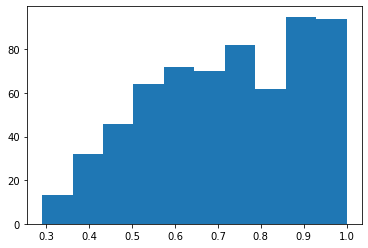

In [258]:
plt.hist(predictproba)

Validamos con k-fold:

In [259]:
Xarr = np.array(X3)
kf = KFold(n_splits=10)
kfoldf1sc = []
lista_mse=[]
for train_index, test_index in kf.split(Xarr, y):
    X_train, X_test = Xarr[train_index], Xarr[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf1=RandomForestClassifier()
    clf1 = clf1.fit(X_train, y_train)
    yhat = clf1.predict(X_test)
    kfoldf1sc.append(f1_score(y_test,yhat, average='macro'))
    lista_mse.append(mean_squared_error(y_test,yhat))
print('F1-score media: ', sum(kfoldf1sc)/len(kfoldf1sc))
print('Mean squared error media: ', sum(lista_mse)/len(lista_mse) )

F1-score media:  0.772085413036266
Mean squared error media:  0.7147619047619047


Hacemos también hold out:

In [260]:
# Aplico hold out
lista_acc=[]
lista_f1=[]
lista_mse=[]
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split( X3, y, test_size=0.3)#, stratify=y)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    lista_acc.append(accuracy_score(y_test,yhat))
    lista_f1.append(f1_score(y_test,yhat,average='macro'))
    lista_mse.append(mean_squared_error(y_test,yhat))
print('accuracy medio: ', sum(lista_acc)/len(lista_acc))
f1mean=sum(lista_f1)/len(lista_f1)
print('F1-score media: ', f1mean)
# print('Desviación estandar de la f1: ', (sum([(i-f1mean)**2 for i in lista_f1])/len(lista_f1))**(1/2))
print('Mean squared error media: ', sum(lista_mse)/len(lista_mse) )

accuracy medio:  0.7691428571428572
F1-score media:  0.7683836159284972
Mean squared error media:  0.740984126984127


Obtenemos una media de f1-score de 0.77 en la validación con un k-fold de 10 splits, con una mean squared error media del 0.71.

Con hold out de 100, obtenemos una media de f1-socer de 0.76 y una mean squared error media de 0.74

#### RandomForest con parámetros por defecto tras aplicar PCA

In [263]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

In [264]:
# Hacemos train_test_split:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3)

In [265]:
# Aplicamos RandomForest
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test,yhat))
print('F1-score: ', f1_score(y_test,yhat, average="macro"))
print('Mean squared error: ', mean_squared_error(y_test,yhat) )
confusion_matrix(y_test, yhat)

Accuracy:  0.7444444444444445
F1-score:  0.7394268142584322
Mean squared error:  0.7873015873015873


array([[113,  12,   8,   6,   0],
       [ 10, 102,   8,   7,   0],
       [ 16,  10,  69,  12,  18],
       [  3,  16,   7,  81,  10],
       [  2,   1,  10,   5, 104]], dtype=int64)

Obtenemos un f1-score de 0.73 y una mean squared error de 0.78

Validamos el método con k-fold:

In [266]:
Xarr = np.array(X_pca)
kf = KFold(n_splits=10)
kfoldf1sc = []
lista_mse=[]
for train_index, test_index in kf.split(Xarr, y):
    X_train, X_test = Xarr[train_index], Xarr[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf1=RandomForestClassifier()
    clf1 = clf1.fit(X_train, y_train)
    yhat = clf1.predict(X_test)
    kfoldf1sc.append(f1_score(y_test,yhat, average='macro'))
    lista_mse.append(mean_squared_error(y_test,yhat))
print('F1-score media: ', sum(kfoldf1sc)/len(kfoldf1sc))
print('Mean squared error media: ', sum(lista_mse)/len(lista_mse) )

F1-score media:  0.7620509597396689
Mean squared error media:  0.7771428571428572


Y aplicamos también hold out:

In [267]:
# Aplico hold out
lista_acc=[]
lista_f1=[]
lista_mse=[]
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split( X_pca, y, test_size=0.3)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    #print("Accuracy: ", accuracy_score(y_test,yhat))
    lista_acc.append(accuracy_score(y_test,yhat))
    lista_f1.append(f1_score(y_test,yhat,average='macro'))
    lista_mse.append(mean_squared_error(y_test,yhat))
print('accuracy medio: ', sum(lista_acc)/len(lista_acc))
f1mean=sum(lista_f1)/len(lista_f1)
print('F1-score media: ', f1mean)
# print('Desviación estandar de la f1: ', (sum([(i-f1mean)**2 for i in lista_f1])/len(lista_f1))**(1/2))
print('Mean squared error media: ', sum(lista_mse)/len(lista_mse) )

accuracy medio:  0.7542222222222225
F1-score media:  0.753604643530452
Mean squared error media:  0.817603174603175


Obtenemos un f1-score media de 0.76 con una mean squared error media de 0.77 con k-fold

### Conclusiones

Tras haber probado varias metodologías, el mejor resultado de f1-score lo obtenemos haciendo un RandomForest con los parámetros por defecto (Obtenemos un resultado equivalente al eliminar feature3, y empeora un poco al aplicar PCA con 5 componentes). Igualmente el error cuadrático medio no mejora cuando aplicamos otras configuraciones. Como dijimos antes, de cara a obtener un modelo que tenga menos fallos en los que estuviera muy seguro de acertar, sería interesante estudiar otras configuraciones con menos hojas por ejemplo.

De modo que finalmente, entrenamos el método elegido con toda la muestra train (jm_train) y predecimos las yhat para X_test (jm_X_test)

In [268]:
clf = RandomForestClassifier()
clf = clf.fit(X, y)
yhat = clf.predict(dfXtest)

In [269]:
dfyhat=pd.DataFrame()
dfyhat['predicciones']=yhat
dfyhat

,predicciones
0,1
1,3
2,2
3,0
4,3
...,...
895,3
896,4
897,0
898,3


In [270]:
# Exportamos a archivo .csv

In [271]:
dfyhat.to_csv("predicciones.csv", index=False)